In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)
import joblib

RANDOM_STATE = 42


In [20]:
# Load dataset
df = pd.read_csv("Data/time-domain-cancer.csv")
df.columns = [c.strip() for c in df.columns]

# Ambil fitur & label
X = df[['SDNN', 'rMSSD', 'pNN50']].values
y = df['Class'].values

print("Preview data:")
display(df.head())
print("Shape:", X.shape, "Label unique:", np.unique(y))


Preview data:


,SDNN,rMSSD,pNN50,Class
0,54,19,1,1
1,158,36,15,1
2,129,24,4,1
3,62,13,0,1
4,101,18,1,1


Shape: (37, 3) Label unique: [0 1]


In [21]:
# Pipeline LDA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

# Param grid LDA
param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage': [None, 'auto']  # hanya berlaku utk lsqr/eigen
}

loo = LeaveOneOut()

# GridSearchCV dengan LOOCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Mean LOOCV accuracy:", grid.best_score_)


Fitting 37 folds for each of 6 candidates, totalling 222 fits
Best params: {'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
Mean LOOCV accuracy: 0.32432432432432434


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
37 fits failed out of a total of 222.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
37 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\L

In [22]:
best_model = grid.best_estimator_

y_true_all = []
y_pred_all = []
y_prob_all = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])
    if hasattr(best_model, "predict_proba"):
        y_prob_all.append(best_model.predict_proba(X_test)[0][1])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_prob_all = np.array(y_prob_all)

print("Classification report (LOOCV):")
print(classification_report(y_true_all, y_pred_all))
cm = confusion_matrix(y_true_all, y_pred_all)
print("Confusion matrix:\n", cm)


Classification report (LOOCV):
              precision    recall  f1-score   support

           0       0.23      0.17      0.19        18
           1       0.38      0.47      0.42        19

    accuracy                           0.32        37
   macro avg       0.30      0.32      0.31        37
weighted avg       0.30      0.32      0.31        37

Confusion matrix:
 [[ 3 15]
 [10  9]]


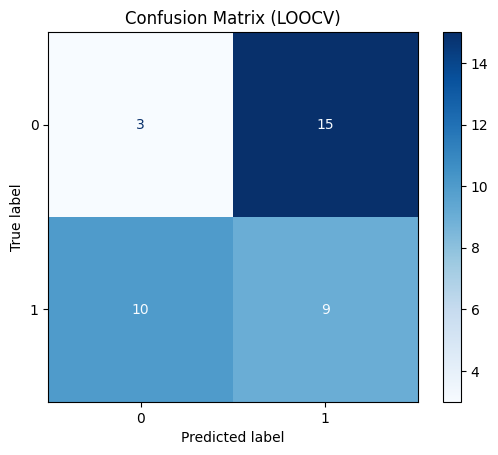

ROC AUC: 0.2982456140350877


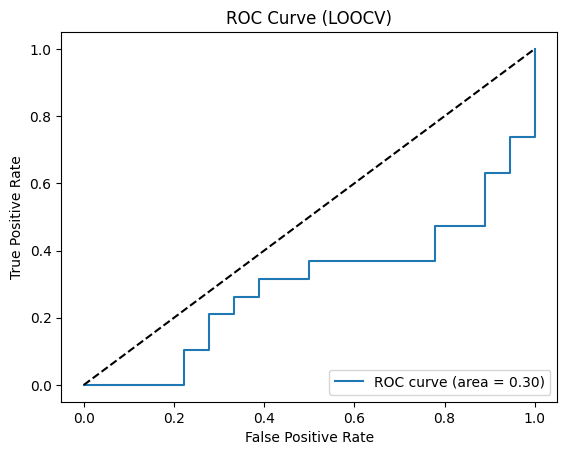

In [23]:
# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (LOOCV)")
plt.show()

# ROC Curve
try:
    auc = roc_auc_score(y_true_all, y_prob_all)
    print("ROC AUC:", auc)
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (LOOCV)")
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("ROC AUC gagal dihitung:", e)


In [24]:
# Buat folder hasil
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Simpan prediksi
out_df = pd.DataFrame({
    "true": y_true_all,
    "pred": y_pred_all,
    "prob": y_prob_all
})
out_df.to_csv("results/loocv_predictions.csv", index=False)

pd.DataFrame(classification_report(y_true_all, y_pred_all, output_dict=True)).transpose() \
    .to_csv("results/loocv_classification_report.csv")

print("Hasil prediksi & laporan disimpan di folder results/")

# Simpan model
best_model.fit(X, y)
joblib.dump(best_model, "models/lda_hrv_loocv.joblib")
print("Model final disimpan di models/lda_hrv_loocv.joblib")


Hasil prediksi & laporan disimpan di folder results/
Model final disimpan di models/lda_hrv_loocv.joblib
